# 3. Predictive Analytics

## Step 1: Testing Multiple Models with Different Strategies

### 3.1 Import Libraries and Load datasets

In [30]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, roc_curve, confusion_matrix, precision_recall_fscore_support, roc_curve
from sklearn.svm import SVC, LinearSVC
from skopt import BayesSearchCV
import pickle
import os

In [31]:

# -------------------------- Load Data --------------------------

# Define file paths
X_train_path = os.path.join("feature_selection", "X_train_selected.csv")
X_test_path = os.path.join("feature_selection", "X_test_selected.csv")
y_train_path = os.path.join("balanced_data", "y_train_balanced.csv")
y_test_path = os.path.join("split_data", "y_test.csv")
cid_path = os.path.join("split_data", "customer_test.csv")

# Try to load datasets and handle errors
try:
    X_train_selected = pd.read_csv(X_train_path)
    X_test_selected = pd.read_csv(X_test_path)
    y_train_balanced = pd.read_csv(y_train_path)
    y_test = pd.read_csv(y_test_path)
    customer_test = pd.read_csv(cid_path)
    
    # Ensure y_train_balanced is a 1D array
    y_train_balanced = y_train_balanced.squeeze()

    print("Datasets loaded successfully!")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Datasets loaded successfully!



🔹 Evaluating Support Vector Machine (SVM) with 10-Fold Cross Validation...
🔍 Tuning hyperparameters for Support Vector Machine (SVM) using Bayesian Optimization with 5-Fold CV...
✅ Best parameters for Support Vector Machine (SVM): OrderedDict({'C': 8.648674412457455, 'kernel': 'rbf'})

📊 Classification Report for Support Vector Machine (SVM) (Test Set Predictions):
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



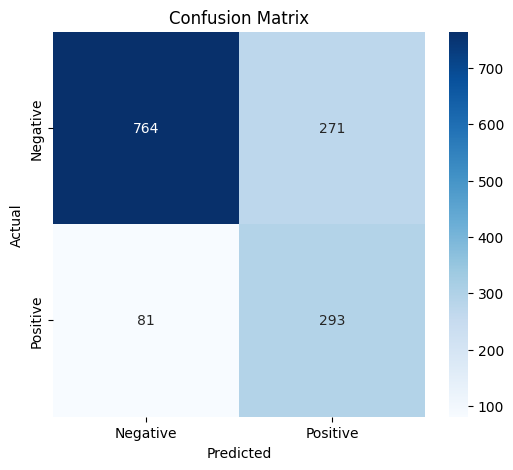

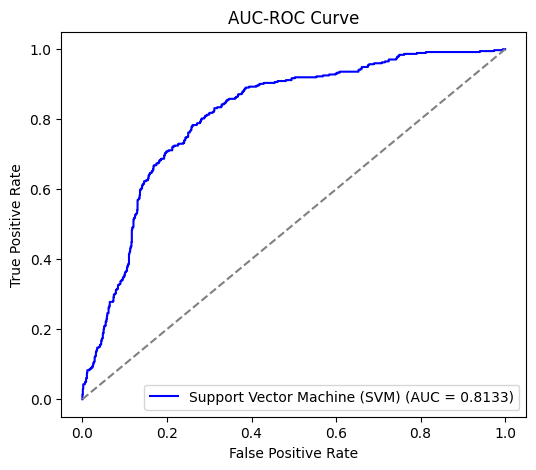


📊 Model Performance Summary:
                          Model  \
0  Support Vector Machine (SVM)   

                                Best Hyperparameters  Test Accuracy  \
0  OrderedDict({'C': 8.648674412457455, 'kernel':...       0.750177   

   Test F1-Score  Test AUC-ROC  Test Precision  Test Recall  
0       0.624733      0.813298        0.519504     0.783422  
✅ Best SVM model saved as 'best_svm_model.pkl'


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, precision_recall_fscore_support, confusion_matrix, roc_curve
from sklearn.svm import SVC
from skopt import BayesSearchCV
import joblib
import os

# -------------------------- Define Bayesian Search Hyperparameter Spaces --------------------------
param_spaces = {
    "Support Vector Machine (SVM)": {
        "C": (0.1, 10),
        "kernel": ["linear", "rbf"],
}
}

# -------------------------- Model Training & Evaluation --------------------------
results = []  # Store results for each model
cv_folds_train = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-Fold CV for Training
cv_folds_hpo = 5  # 5-Fold CV for Bayesian Optimization

# Initialize the SVM model
model_name = "Support Vector Machine (SVM)"
model = SVC(probability=True)

print(f"\n🔹 Evaluating {model_name} with 10-Fold Cross Validation...")

try:
    # Check if model has hyperparameter tuning space
    if model_name in param_spaces and param_spaces[model_name]:
        print(f"🔍 Tuning hyperparameters for {model_name} using Bayesian Optimization with {cv_folds_hpo}-Fold CV...")

        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_spaces[model_name],
            n_iter=50,  # Number of iterations for Bayesian Optimization
            cv=cv_folds_hpo,  # 5-Fold CV inside Bayesian Search
            scoring="f1",
            n_jobs=-1,
            random_state=42,
        )

        bayes_search.fit(X_train_selected, y_train_balanced)
        model = bayes_search.best_estimator_
        print(f"✅ Best parameters for {model_name}: {bayes_search.best_params_}")

    # Perform 10-Fold Cross-Validation on Training Data (AFTER HPO)
    y_pred_cv = cross_val_predict(model, X_train_selected, y_train_balanced, cv=cv_folds_train)

    # Compute Cross-Validation Scores (but don't store or print them here)
    f1_scores = cross_val_score(model, X_train_selected, y_train_balanced, cv=cv_folds_train, scoring="f1")

    # Compute Mean Scores Across Folds
    f1_train = f1_scores.mean() if len(f1_scores) > 0 else 0

    # Train the model on full training data before final evaluation
    model.fit(X_train_selected, y_train_balanced)

    # Predict on Test Set
    y_pred_test = model.predict(X_test_selected)
    y_prob_test = model.predict_proba(X_test_selected)[:, 1]  # Get probability scores for ROC curve (for binary classification)

    # Compute Performance Metrics on Test Set
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_roc_test = roc_auc_score(y_test, y_prob_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

    # Print Classification Report (Test Set)
    print(f"\n📊 Classification Report for {model_name} (Test Set Predictions):")
    print(classification_report(y_test, y_pred_test))

    # -------------------------- Confusion Matrix --------------------------
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # -------------------------- AUC-ROC Curve --------------------------
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc_roc_test:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend()
    plt.show()

    # -------------------------- Save and Display Results --------------------------
    results = {
        "Model": model_name, 
        "Best Hyperparameters": str(bayes_search.best_params_),
        "Test Accuracy": accuracy_test,
        "Test F1-Score": f1_test, 
        "Test AUC-ROC": auc_roc_test,
        "Test Precision": precision,
        "Test Recall": recall
    }
    results_df = pd.DataFrame([results])
    print("\n📊 Model Performance Summary:")
    print(results_df)

    # Save the best SVM model using pickle
    with open("best_svm_model.pkl", "wb") as file:
        pickle.dump(model, file)
    print("✅ Best SVM model saved as 'best_svm_model.pkl'")

except Exception as e:
    print(f"❌ Error evaluating {model_name}: {e}")

In [33]:
# -------------------------- Create DataFrame --------------------------
# Combine X_test_selected, y_pred, and y_prob into a single DataFrame
result_df = X_test_selected.copy()  # Start with X_test_selected
result_df['y_pred'] = y_pred_test  # Add predictions to the DataFrame
result_df['Class_1_Probability'] = y_prob_test  # Add Class 1 probability to the DataFrame

# -------------------------- Display the DataFrame --------------------------
# Optional: Print the DataFrame to console (if you want to inspect the first few rows)
print(result_df.head())



   total_charges    tenure  payment_method_Electronic check  monthly_charges  \
0       0.990743  1.000000                              0.0         0.954046   
1       0.104318  0.111111                              0.0         0.815185   
2       0.374321  0.569444                              0.0         0.597403   
3       0.170006  0.250000                              1.0         0.595904   
4       0.691871  1.000000                              0.0         0.640360   

   contract_Two year  internet_service_Fiber optic  internet_service_No  \
0                1.0                           1.0                  0.0   
1                0.0                           1.0                  0.0   
2                0.0                           0.0                  0.0   
3                0.0                           1.0                  0.0   
4                1.0                           0.0                  0.0   

   payment_method_Credit card (automatic)  dependents  contract_One 

In [34]:
# Ensure customer_test is a 1D Series instead of a 2D DataFrame
if customer_test.shape[1] == 1:  
    customer_test = customer_test.squeeze()  # Convert to Series if it has only one column

# Now, add Customer_ID back to the result dataframe
result_df['customer_id'] = customer_test.values  # Ensures shape matches

# Reorder columns if needed (placing customer_id first)
column_order = ['customer_id'] + [col for col in result_df.columns if col != 'customer_id']
result_df = result_df[column_order]

# Print the DataFrame to inspect
print(result_df.head())

  customer_id  total_charges    tenure  payment_method_Electronic check  \
0  4376-KFVRS       0.990743  1.000000                              0.0   
1  2754-SDJRD       0.104318  0.111111                              0.0   
2  9917-KWRBE       0.374321  0.569444                              0.0   
3  0365-GXEZS       0.170006  0.250000                              1.0   
4  9385-NXKDA       0.691871  1.000000                              0.0   

   monthly_charges  contract_Two year  internet_service_Fiber optic  \
0         0.954046                1.0                           1.0   
1         0.815185                0.0                           1.0   
2         0.597403                0.0                           0.0   
3         0.595904                0.0                           1.0   
4         0.640360                1.0                           0.0   

   internet_service_No  payment_method_Credit card (automatic)  dependents  \
0                  0.0                      

In [35]:
# Create directory if it doesn't exist
save_dir = "churn_data"
os.makedirs(save_dir, exist_ok=True)

# Define file path for saving
result_df_path = os.path.join(save_dir, "churn_results.csv")

# Save the filtered DataFrame as CSV, preserving the index
result_df.to_csv(result_df_path, index=True)

# Optional: Print the filtered DataFrame to inspect the first few rows
print(result_df.head())

# Confirmation message
print(f"\n✅ Filtered churn data saved successfully at '{result_df_path}'")


  customer_id  total_charges    tenure  payment_method_Electronic check  \
0  4376-KFVRS       0.990743  1.000000                              0.0   
1  2754-SDJRD       0.104318  0.111111                              0.0   
2  9917-KWRBE       0.374321  0.569444                              0.0   
3  0365-GXEZS       0.170006  0.250000                              1.0   
4  9385-NXKDA       0.691871  1.000000                              0.0   

   monthly_charges  contract_Two year  internet_service_Fiber optic  \
0         0.954046                1.0                           1.0   
1         0.815185                0.0                           1.0   
2         0.597403                0.0                           0.0   
3         0.595904                0.0                           1.0   
4         0.640360                1.0                           0.0   

   internet_service_No  payment_method_Credit card (automatic)  dependents  \
0                  0.0                      